In [1]:
import re
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import os
from os.path import join, exists

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, concatenate
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split

nltk.download('stopwords')

# increase plot size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read File

In [2]:
#drop NA values and check if it's a string
df = pd.read_csv('full_photo_reviews_dc.csv', header=None,  names=['URL', 'Name', 'Title', 'Review'])
df.dropna(subset=['Name'], inplace=True)
df.dropna(subset=['Title'], inplace=True)
df.dropna(subset=['Review'], inplace=True)
df = df[df['Name'].apply(lambda x: x != "" and isinstance(x, str) )]
df = df[df['Title'].apply(lambda x: x != "" and isinstance(x, str) )]
df = df[df['Review'].apply(lambda x: x != "" and isinstance(x, str) )]
df

,URL,Name,Title,Review
0,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Excellent new contemporary hotel,I stayed here 3 nights for business. As a fema...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Fabulous place to stay,"I loved the location at the Wharf. The room, a..."
2,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Don't stay on the 12th Floor!,First time to Washington and this area. We did...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Suites are amazing,Excellent new Intercontinental Hotel in Washin...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Weekend in DC,We arrived here from Scotland and were VERY im...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Good location for are things,I booked a last minute business trip to DC. Lu...
6,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,The Wharf,I understand the Wharf is the latest IT thing ...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Beautiful hotel (minor kinks),"Stayed there for a week with my wife, had supe..."
8,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Exquisite hotel with fabulous location.,The Willard is obviously a DC iconic landmark....
9,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Great hotel in newly revitalized area...,My husband and I stayed just one night for a q...


In [10]:
#create an id for each hotel based on hotel name for training purposes
nameMap = {}
nameById = {}
nameCount = 0
def nameCategory(name):
    global nameCount
    name = name.strip().lower()
    if name not in nameMap:
        nameMap[name] = nameCount
        nameCount += 1
    nameById[ nameMap[name] ] = name
    return nameMap[name]
df['id'] = df['Name'].apply(nameCategory)
df['text'] = df['Title']  + " " + df['Review']

In [11]:
df

,URL,Name,Title,Review,id,text
0,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Excellent new contemporary hotel,I stayed here 3 nights for business. As a fema...,0,Excellent new contemporary hotel I stayed here...
1,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Fabulous place to stay,"I loved the location at the Wharf. The room, a...",0,Fabulous place to stay I loved the location at...
2,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Don't stay on the 12th Floor!,First time to Washington and this area. We did...,0,Don't stay on the 12th Floor! First time to Wa...
3,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Suites are amazing,Excellent new Intercontinental Hotel in Washin...,0,Suites are amazing Excellent new Intercontinen...
4,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Weekend in DC,We arrived here from Scotland and were VERY im...,0,Weekend in DC We arrived here from Scotland an...
5,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Good location for are things,I booked a last minute business trip to DC. Lu...,0,Good location for are things I booked a last m...
6,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,The Wharf,I understand the Wharf is the latest IT thing ...,0,The Wharf I understand the Wharf is the latest...
7,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Beautiful hotel (minor kinks),"Stayed there for a week with my wife, had supe...",0,Beautiful hotel (minor kinks) Stayed there fo...
8,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Exquisite hotel with fabulous location.,The Willard is obviously a DC iconic landmark....,0,Exquisite hotel with fabulous location. The W...
9,https://www.tripadvisor.com/Hotel_Review-g2897...,InterContinental Washington D.C. - The Wharf,Great hotel in newly revitalized area...,My husband and I stayed just one night for a q...,0,Great hotel in newly revitalized area... My hu...


In [4]:
df['Name'].describe()


count        7447
unique        135
top       No name
freq          323
Name: Name, dtype: object

## Remove hotels without name and Keep hotels with review >= 50

In [12]:
df = df[df['Name'] != 'No name']

hotelReviewStat = df.groupby('Name').count()[['URL']]
hotelReviewStat = hotelReviewStat[hotelReviewStat['URL'] >= 50]

keepHotels = set(hotelReviewStat.index.values)

df = df[df['Name'].apply(lambda x: x in keepHotels)]

In [13]:
df['Name'].describe()

count                    5715
unique                     50
top       Omni Shoreham Hotel
freq                      288
Name: Name, dtype: object

# Load GloVe

In [7]:
# Load embedings
data_folder = './'
glove_filename = os.path.join(data_folder, 'glove.840B.300d.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract ./glove.840B.300d.txt
Embeddings size: 400000


In [14]:
### Create sequence
#Embedding -- pre-trained word vectors -- to get context
NUM_WORDS = len(embeddings)

#vocabulary_size = 10000
reviews = df['text']
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))


Found 21453 unique tokens.


In [15]:
words_len = min(NUM_WORDS, len(word_index))
embedding_dim = 300
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1

In [16]:
from collections import defaultdict

#count number of symbols
max_word_count_text = 0
text_count = defaultdict(int)

for sentence in reviews:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1

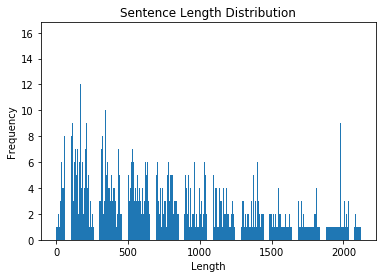

In [17]:
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()


In [18]:
print('Max word text: %d' % max_word_count_text)

Max word text: 18448


In [19]:
#maxlen = 100
max_seq_length = 20
data = pad_sequences(sequences, maxlen = max_seq_length)

In [20]:
#labels = np.array(df['id'])
#labels = to_categorical(np.asarray(df['id']))
labels = np.array(df['id'])
print('Shape of label tensor:', labels.shape)

('Shape of label tensor:', (5715,))


In [ ]:
labels[0]

In [21]:
import random

anchor_data = []
positive_data = []
negative_data = []

# For neg_y we need any hotel that is different from the anchor
# For pos_y we need any review that's from the same hotel that is in anchor

for i in range(len(data)):
    y = labels[i]
    neg_y = i
    while labels[neg_y] == y:
        neg_y = random.randint(0, len(data) - 1)
    
    pos_y = i
    while labels[pos_y] == y or pos_y == i:
        pos_y = random.randint(0, len(data) - 1)
    
    anchor_data.append(data[i])
    positive_data.append(data[pos_y])
    negative_data.append(data[neg_y])

    
anchor_data = np.array(anchor_data)
positive_data = np.array(positive_data)
negative_data = np.array(negative_data)

stack_data = np.hstack((anchor_data, positive_data, negative_data))

# take 10% to test data
X_train, X_test, y_train, y_test = train_test_split(stack_data, labels, test_size=0.1)

X_train = np.hsplit(X_train, 3)
X_test = np.hsplit(X_test, 3)


### ||f(A) - f(P)||^2  <=  ||f(A) - f(N)||^2   
   d(A,P)        <=       d(A,N)
      
### ||f(A) - f(P)||^2 - ||f(A) - f(N)||^2  <=  0

f = encoding, A = anchor, P = positive, N = negative; ||||^2 = squared norm/distance

We want to achieve that, but also need to prevent the NN from encoding everything the same values (that is, outputing the trivial solutions).
To do that we need to make it:

### ||f(A) - f(P)||^2 - ||f(A) - f(N)||^2  <=  -α

α = margin (from SVMs)

If α = 0.2, and d(A,P) = 0.5, then d(A,N) must be >= 0.7



https://www.coursera.org/lecture/convolutional-neural-networks/triplet-loss-HuUtN


In [76]:
def triplet_loss(y_true, y_pred):
    size = y_pred.shape[1] / 3

    anchor = y_pred[:,0:size]
    positive = y_pred[:,size: 2 * size]
    negative = y_pred[:,2 * size: 3 * size]
    alpha = 0.2
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)
    return loss


In [77]:
# The original model

def base_model(out_dim):
    model = Sequential()
    model.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = max_seq_length,
                     trainable = False,
                     name = 'embedding'))
    #model.add(LSTM(512, dropout=0.2, return_sequences = True)) #, recurrent_dropout=0.2))
    model.add(LSTM(512, dropout=0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(out_dim, activation='sigmoid'))
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [79]:
anchor_input = Input(shape=(max_seq_length,), dtype='int32', name = 'anchor')
positive_input = Input(shape=(max_seq_length,), dtype='int32', name = 'positive')
negative_input = Input(shape=(max_seq_length,), dtype='int32', name = 'negative')
    
base_network = base_model(100)

anchor_out = base_network(anchor_input)
positive_out = base_network(positive_input)
negative_out = base_network(negative_input)

merged_vector = concatenate([anchor_out, positive_out, negative_out], axis=-1)

model = Model(inputs = [anchor_input, positive_input, negative_input],
              outputs = merged_vector)

model.compile(optimizer=Adam(), loss = triplet_loss)


# Train


In [80]:
# take 22% to validation from train set
history = model.fit(X_train, y_train, validation_split=0.20, epochs=5)

Train on 4114 samples, validate on 1029 samples
Epoch 1/5
4114/4114 [==============================] - 228s 55ms/step - loss: 0.2003 - val_loss: 0.2000
Epoch 2/5
4114/4114 [==============================] - 333s 81ms/step - loss: 0.1993 - val_loss: 0.2000
Epoch 3/5
4114/4114 [==============================] - 292s 71ms/step - loss: 0.2002 - val_loss: 0.2000
Epoch 4/5
4114/4114 [==============================] - 299s 73ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 5/5
4114/4114 [==============================] - 256s 62ms/step - loss: 0.2000 - val_loss: 0.2000


In [28]:
history_dict = history.history
history_dict.keys()

['loss', 'val_loss']

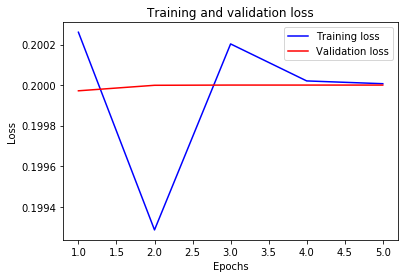

In [81]:

#acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

KeyError: 'acc'

<Figure size 432x288 with 0 Axes>

In [ ]:
# Test data

loss, accuracy = model.evaluate(X_test, y_test)
print('loss     = ', loss)
print('accuracy = ', accuracy)

In [110]:
#labels = np.array(labels)
ynew = model.predict_classes(data)
correctFrame = pd.DataFrame(columns = df.columns)
failedFrame = pd.DataFrame(columns = df.columns)
for i in range(len(data)):
    if ynew[i] == df.iloc[i]['id']: # np.argmax(labels[i], axis=0):
        correctFrame = correctFrame.append(df.iloc[i], ignore_index=True)
    else:
        failedFrame = failedFrame.append(df.iloc[i], ignore_index=True)
        #print("X=%s, Predicted=%s" % (data[i], labels[i]))
        #print("Predicted %d" % (labels[i]))
        #print(df.iloc[i]["Name"])
        #print(df.iloc[i].text)
        #print("")

# Test

1. Take base_network
2. Try to encode all reviews
3. Encode test data and try to find similar data from training data

Encode = predict using base_network because it returns a vector


In [82]:
def encode(x):
    return base_network.predict(np.array([x]))

def findHotel(hotels, encoding):
    min_dist = 10000
    identity = 'unknown'
    
    for (name, enc) in hotels:
        dist = np.linalg.norm(enc - encoding)
        
        if dist < min_dist:
            min_dist = dist
            identity = name
            
    return identity

In [83]:
hotels = []
for i in range(len(X_train[0])):
    review = X_train[0][i] # take anchor
    id = y_train[i]
    name = nameById[id]
    vec = encode(review)
    hotels.append((name, vec))

In [84]:
unknown = 0
count = 0
for i in range(len(X_test[0])):
    review = X_test[0][i] # take anchor
    vec = encode(review)
    name = findHotel(hotels, vec)
    id = y_train[i]
    true_name = nameById[id]
    
    if true_name == name:
        count += 1

print("Hotels %d" % len(hotels))
print("Total test %d" % len(X_test[0]))
print("Discoverd %d" % count)

Hotels 5143
Total test 572
Discoverd 11


In [85]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from sklearn.manifold import TSNE

arr = []
for (name, enc) in hotels:
    arr.append(enc[0])
    
tsne = TSNE(perplexity=40, n_components = 2, n_iter=300)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
#z_coords = Y[:, 2]


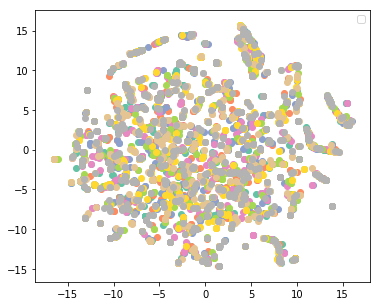

In [86]:

#plt.figure(figsize=(6, 5))
fig = plt.figure(figsize=(6, 5))
ax = plt.axes() #projection='3d')

#ax.scatter(x_coords, y_coords)

takeSize = nameCount
for i in range(takeSize):
    name = nameById[i]
    ax.scatter(Y[y_train == i, 0], Y[y_train == i, 1], c = plt.cm.Set2(i / float(takeSize))) #, label=name)

plt.legend()
plt.show()
